In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
def Entropy_multiclass(p):
    p = p[p>0]
   
    logs = np.log2(p)
   
    entropies = p*logs 
    
    return -np.sum(entropies)
    

In [27]:
ar = np.array([0.05,0.3,0.2,0.04])
print(Entropy_multiclass(ar))

1.3873259495626915


In [2]:
def IG_multiclass(root,L,R):
    n_classes = np.max(root) + 1 
    roots = np.bincount(root,minlength=n_classes)/root.shape[0]
    lefts = np.bincount(L,minlength=n_classes)/L.shape[0]
    rights = np.bincount(R,minlength=n_classes)/R.shape[0]
    E = Entropy_multiclass(roots)
    El = Entropy_multiclass(lefts)
    Er = Entropy_multiclass(rights)
    gamma = L.shape[0]/roots.shape[0]
    return E - (gamma*El + (1-gamma)*Er)

In [3]:
def best_split_multi(X,Y,i,gaps):
    mn = X[:,i].min()
    mx = X[:,i].max()
    rng = np.linspace(mn,mx,gaps)
    ig =0
    val =0
    for j in rng:
        left = Y[X[:,i]<j]
        right = Y[X[:,i]>=j]
        if left.shape[0] == 0 or right.shape[0] == 0:
            continue
        ig_gain = IG_multiclass(Y,left,right)
        if ig_gain>ig:
            ig =ig_gain
            val = j
    return ig,val

In [4]:
class DecisionTree:
    def __init__(self,val=None,max_depth=None):
        self.val = val
        self.max_depth = max_depth
        self.left = None
        self.right = None
        self.is_leaf = False
        self.label = None
        self.feature = None
    def Entropy(self,p):
        p = p[p>0]
        logs = np.log2(p)
        entropies = p*logs
        return -np.sum(entropies)
    def IG(self,root,L,R):
        n_classes = np.max(root) + 1 
        roots = np.bincount(root,minlength=n_classes)/root.shape[0]
        lefts = np.bincount(L,minlength=n_classes)/L.shape[0]
        rights = np.bincount(R,minlength=n_classes)/R.shape[0]
        E = self.Entropy(roots)
        El = self.Entropy(lefts)
        Er = self.Entropy(rights)
        gamma = L.shape[0]/(R.shape[0]+L.shape[0])
        return E - (gamma*El + (1-gamma)*Er)
    def best_split(self,X,Y,f,gaps):
        mn = X[:,f].min()
        mx = X[:,f].max()
        rng = np.linspace(mn,mx,gaps)
        ig=0
        val=0
        for j in rng:
            left = Y[X[:,f]<j]
            right = Y[X[:,f]>=j]
            if left.shape[0] == 0 or right.shape[0] == 0:
                continue
            ig_gain = self.IG(Y,left,right)
            if ig_gain>ig:
                ig =ig_gain
                val = j
        
        return ig,val
    def Grow_Tree(self,X,Y,lvl):
        n_classes = np.max(Y) + 1 
        p = np.bincount(Y,minlength=n_classes)/Y.shape[0]
        E = self.Entropy(p)
        if (self.max_depth is not None and lvl >= self.max_depth) or E<0.2:
            lbl = np.argmax(p)
            self.is_leaf = True 
            self.label = lbl
            return
        
        ig =0
        val =0
        feature=0
        for i in range(X.shape[1]):
            ig_gain,value = self.best_split(X,Y,i,10)
            if ig_gain >ig:
                ig = ig_gain
                val = value
                feature=i
        self.feature = feature
        self.val=val
        self.ig = ig 
        left_x = X[X[:,feature]<val]
        left_y = Y[X[:,feature]<val]
        right_x = X[X[:,feature]>=val]
        right_y = Y[X[:,feature]>=val]
        if left_x.shape[0] ==0 or right_x.shape[0] ==0 or ig<0.004:
            lbl = np.argmax(p)
            self.is_leaf = True 
            self.label = lbl
            return
        self.left = DecisionTree()
        self.right = DecisionTree()
        self.left.Grow_Tree(left_x,left_y,lvl+1)
        self.right.Grow_Tree(right_x,right_y,lvl+1)
            
        
    def fit(self,X,Y):
        self.Grow_Tree(X,Y,0)
        
    def predict_point(self,p):
        if self.is_leaf:
            return self.label 
        if p[self.feature] <= self.val:
            return self.left.predict_point(p)
        else:
            return self.right.predict_point(p)
    def predict(self,X):
        preds = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            prediction = self.predict_point(X[i])
            preds[i] = prediction
        return preds 
        
        
        

In [5]:
from sklearn.datasets import load_iris

In [6]:
X, y = load_iris(return_X_y=True)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.3)

In [9]:
X_train.shape

(105, 4)

In [10]:
X_test.shape

(45, 4)

In [13]:
Dc3 = DecisionTree()
Dc3.fit(X_train,Y_train)

In [14]:
preds_train =Dc3.predict(X_train)

In [15]:
from sklearn.metrics import classification_report

In [16]:
print(classification_report(Y_train,preds_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       0.97      1.00      0.99        36
           2       1.00      0.97      0.99        37

    accuracy                           0.99       105
   macro avg       0.99      0.99      0.99       105
weighted avg       0.99      0.99      0.99       105



In [17]:
preds_test = Dc3.predict(X_test)

In [18]:
print(classification_report(Y_test,preds_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.87      0.93      0.90        14
           2       0.92      0.85      0.88        13

    accuracy                           0.93        45
   macro avg       0.93      0.92      0.93        45
weighted avg       0.93      0.93      0.93        45



In [20]:
from matplotlib.colors import ListedColormap

In [21]:
cmap = ListedColormap(['pink','purple','black','orange'])
cmap_bold = ListedColormap(['red', 'green','blue','yellow'])


In [22]:
def decision_boundary_multiclass(X,y,M):
    features = X.shape[1]
    pairs = []
    for i in range(features):
        for j in range(i,features):
            pairs.append([i,j])
    for idx,p in enumerate(pairs,1):
        X_pair = X[:,p]
        M.fit(X_pair,y)
        x1_mn,x1_mx = X_pair[:,0].min()-1,X_pair[:,0].max()+1
        x2_mn,x2_mx= X_pair[:,1].min()-1,X_pair[:,1].max()+1
        X_grid,Y_grid = np.meshgrid(np.arange(x1_mn,x1_mx,0.1),np.arange(x2_mn,x2_mx,0.1))
        plt.contourf(X_grid,Y_grid,M.predict(np.array([X_grid.ravel(),Y_grid.ravel()]).T).reshape(X_grid.shape),alpha=0.70,cmap=cmap)
        plt.scatter(X_pair[:,0],X_pair[:,1],c=y,cmap=cmap_bold, edgecolor='k')
       
        plt.title(f"Features: {p[0]} vs {p[1]}")
    plt.title("Decision Boundary of Decision Tree")
    plt.tight_layout()
    plt.show()
        

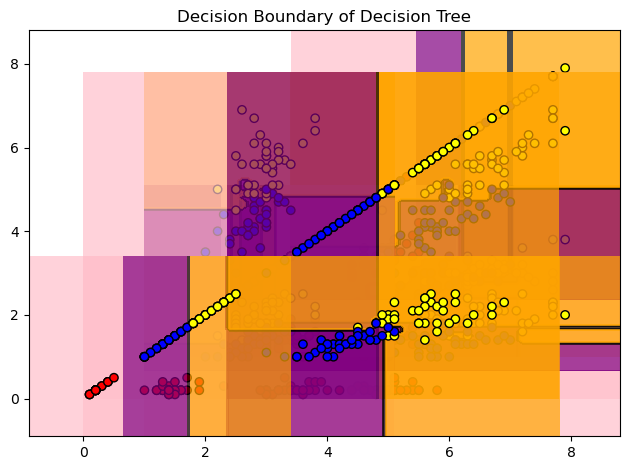

In [23]:
decision_boundary_multiclass(X_train,Y_train,Dc3)

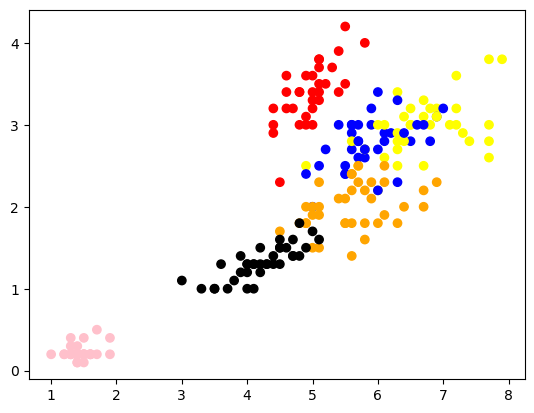

In [24]:
plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=cmap_bold)
plt.scatter(X_train[:,2],X_train[:,3],c=Y_train,cmap=cmap)
plt.show()